## Visualize tracks from .h5 file:
Tested with dlc annotation output.
Functions addapted from Paul Nührenberg: https://github.com/PaulNueh/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt

from glob import glob
from utils import *
from colmap import Scene

## Set to input path directory containing both labeled folders (for example: '2min_testrun-Eduardo-2018-11-30/labeled-data') :
path = '/run/media/cronk/Samsung_T5/DeepLabCut/2min_testrun-Eduardo-2018-11-30/labeled-data'

## Set corresponding camera names:
camera_names = ['camera_1_img','camera_2_img']

[(0, 'btgrouper'), (1, 'goatfish'), (2, 'octopus'), (3, 'wrasse1'), (4, 'wrasse2')]


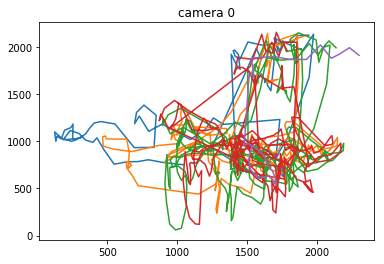

[(0, 'btgrouper'), (1, 'goatfish'), (2, 'octopus'), (3, 'wrasse1'), (4, 'wrasse2')]


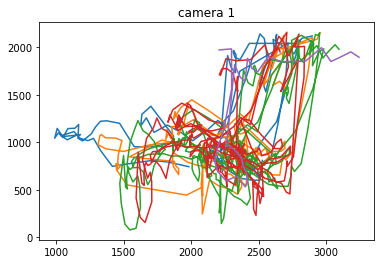

In [3]:
## Resize factor of images:
resized_factor = 2

## glob goes into directories and reads out .h5 files:
data = sorted(glob(os.path.join(path,'*','*.h5')))
scorer = 'Eduardo'

# ## Loops over every .h5 file plotting all classes aka. 'body parts' in seperate colors:
for k,file in enumerate(data):
    data = {}
    x_list = []
    y_list = []
    identities = []
    frame_idx = []
    
    tracks = pd.read_hdf(file)
    tracks = tracks.to_dict('split')
    tracks['data'] = np.asarray(tracks['data'])
    
    for ind in np.unique([(i,t[1]) for i,t in enumerate(tracks['columns'])],axis=1):
        track = tracks['data'][:,int(ind[0])]
        
        if int(ind[0]) % 2 == 0:
            identities.append(np.repeat(ind[1],track.shape[0]))
            frame_idx.append(np.arange(len(tracks['index'])))
            x_list.append(track)
        else:
            y_list.append(track)
    
    ## Create mask that eliminates 'nan' from data set:
    mask = np.isfinite(np.concatenate(x_list))
    
    ## Divided by downsized factor of images:
    data['X'] = np.concatenate(x_list)[mask]
    data['Y'] = np.concatenate(y_list)[mask]
    
    data['IDENTITY'] = np.concatenate(identities)[mask]    
    data['FRAME_IDX'] = (np.concatenate(frame_idx)[mask] * (25/3)).astype(np.int)

    ## Convert identities to numerical values:
    for i,j in enumerate(np.unique(data['IDENTITY'])):
        data['IDENTITY'][data['IDENTITY']==j] = i
    data['IDENTITY'] = data['IDENTITY'].astype(np.int) 
    
    ## Print correspondences:
    print(list(enumerate(np.unique(identities))))
    
    for obj in np.unique(data['IDENTITY']):
#         plt.title(str('camera '+str(k)+str(obj)))
        plt.title(str('camera '+str(k)))
        plt.plot(data['X'][data['IDENTITY']==obj],data['Y'][data['IDENTITY']==obj])
    plt.show()
    
    ## Save tracks to pickle (.pkl) file:
    tracks = tracks_from_pool(data)
    save(tracks,os.path.join('/run/media/cronk/Samsung_T5/0',camera_names[k]+'.pkl'))

## 3D reconstruction of tracks:
Incorporating COLMAP output files (images.bin, points3D.bin, cameras.bin, project.ini)  
Functions addapted from Paul Nührenberg: https://github.com/PaulNueh/

In [4]:
model_path = '/run/media/cronk/Samsung_T5/0'
tracks_path = '/run/media/cronk/Samsung_T5/0'
camera_ids = [1,2]

scene = Scene(model_path, tracks_path, camera_ids, camera_names, image_path='', output_path='', input_format='jpg')
scene.reconstruct_cameras()

In [5]:
for camera_id in scene.cameras:
    scene.cameras[camera_id].get_tracks()
    scene.cameras[camera_id].tracks = interpolate_tracks(scene.cameras[camera_id].tracks,masked=True)

/usr/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [6]:
scene.triangulate_tracks_3d()

In [7]:
%matplotlib qt

## print camera path:
# plt.plot(scene.cameras[1].translations[:,0],scene.cameras[1].translations[:,1])
# plt.show()

## print 3d tracks:
plot_tracks_3d(scene.tracks_3d)

### Save tracks as .ply file:

In [8]:
scene.get_points3d()
scene.points3d.shape

(448569, 6)

In [15]:
## saving scene and tracks:
scene.generate_pointcloud('scene_1')

### Save tracks as .csv  file:

In [ ]:
write_tracks_pooled(scene.tracks_3d,'output.csv')